In [ ]:
import os
import keras
import matplotlib.style as style
import numpy as np
import tables
from PIL import Image
from keras import optimizers
from keras.applications import VGG16
from keras.callbacks import Callback
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

style.use('seaborn-whitegrid')

### Open images and convert to NumPy arrays

In [15]:
pic = Image.open('data/gestures_data/00/01_palm/frame_00_01_0001.png')

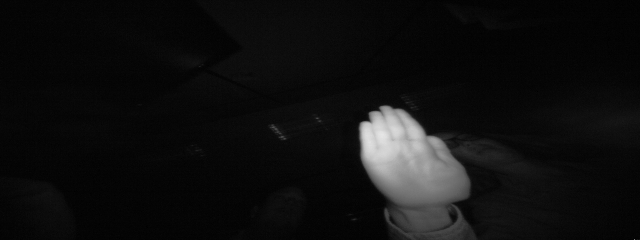

In [16]:
pic

In [4]:
image = image_utils.load_img(path='data/frame_02.png', target_size=(224, 224))
image = image_utils.img_to_array(image)

In [5]:
image.shape

(224, 224, 3)

In [7]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('/home/ubuntu/project_kojak/data/gestures_data/00'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1

In [8]:
lookup

{'06_index': 0,
 '10_down': 1,
 '04_fist_moved': 2,
 '01_palm': 3,
 '03_fist': 4,
 '07_ok': 5,
 '08_palm_moved': 6,
 '05_thumb': 7,
 '02_l': 8,
 '09_c': 9}

In [4]:
def get_data(start, stop):
    x_data = []
    y_data = []
    datacount = 0 # We'll use this to tally how many images are in our dataset
    for i in range(start, stop): # Loop over the ten top-level folders
        for j in os.listdir('./data/gestures_data/0' + str(i) + '/'):
            if not j.startswith('.'): # Again avoid hidden folders
                count = 0 # To tally images of a given gesture
                for k in os.listdir('./data/gestures_data/0' + 
                                    str(i) + '/' + j + '/'):
                                    # Loop over the images
                    img = Image.open('./data/gestures_data/0' + 
                                     str(i) + '/' + j + '/' + k).convert('L')
                                    # Read in and convert to greyscale
                    img = img.resize((224, 224))
                    arr = np.array(img)
                    x_data.append(arr) 
                    count = count + 1
                y_values = np.full((count, 1), lookup[j]) 
                y_data.append(y_values)
                datacount = datacount + count
                
    return x_data, y_data

In [5]:
def process_data(x_data, y_data):
    x_data = np.array(x_data, dtype = 'float32')
    # x_data = np.array(x_data, dtype=np.uint8)
    x_data = x_data.reshape((len(x_data), 224, 224, 1))
    x_data /= 255
    
    y_data = np.array(y_data)
    y_data = y_data.reshape(len(x_data), 1)
    y_data = to_categorical(y_data)
    return x_data, y_data

### Train-Test Split

Train-test split - totally separating images from the first 8 people, and the last 2 people

In [9]:
X_train, y_train = get_data(0,8)
X_train, y_train = process_data(X_train, y_train)
X_test, y_test = get_data(8,10)
X_test, y_test = process_data(X_test, y_test)

In [ ]:
x_data_2 = []
y_data_2 = []
datacount = 0
for i in range(8,10):
    for j in os.listdir('./data/gestures_data/0' + str(i) + '/'):
        if not j.startswith('.'):
            count = 0
            for k in os.listdir('./data/gestures_data/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('./data/gestures_data/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((224, 224))
                arr = np.array(img)
                x_data_2.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data_2.append(y_values)
            datacount = datacount + count
            print(datacount)

In [149]:
x_data = np.array(x_data, dtype = 'float32')

# x_data = x_data.reshape((16000, 224, 224, 1))
# x_data /= 255

### Save (and load) the X and y

In [105]:
hdf5_file = tables.open_file('train_test_split.h5', mode='r')
X_train = np.array(hdf5_file.root.X_train)
y_train = np.array(hdf5_file.root.y_train)
X_test = np.array(hdf5_file.root.X_test)
y_test = np.array(hdf5_file.root.y_test)
hdf5_file.close()

### VGG Models

In [ ]:
# Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(
    weights='imagenet',
    include_top=False,
)
model_vgg16_conv.summary()

# Create your own input format (here 224x224x3)
img_input = Input(shape=(224, 224, 3), name='image_input')

# makes the layers non-trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# Use the generated model 
output_vgg16_conv = model_vgg16_conv(img_input)

# Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)  # here the 2 indicates binary (3 or more is multiclass)

# Create your own model 
my_model = Model(input=img_input, output=x)

# In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()


In [100]:
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
optimizer1 = optimizers.Adam() # Adam is like a gradient descent (way to find parameters)

In [101]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


In [ ]:
base_model = model1  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)

predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.summary()

model.fit(X_train[:500], y_train[:500], epochs=4, batch_size=64, validation_data=(X_test[:500], y_test[:500]),
          verbose=1, callbacks=[MetricsCheckpoint('logs')])

In [ ]:
from sklearn.utils import class_weight
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [36]:
x_data.shape

(16000, 224, 224, 1)

In [38]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()
datagen.fit(x_data)
X_batch = datagen.flow(x_data, y_data, batch_size=64)

In [ ]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(x_data, augment=True, seed=seed)
# mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    './data/gestures_data',
    class_mode=None,
    seed=seed)

# mask_generator = mask_datagen.flow_from_directory(
#     'data/masks',
#     class_mode=None,
#     seed=seed)

# combine generators into one which yields image and masks
# train_generator = zip(image_generator, mask_generator)

model.fit_generator(
    train_generator,
    steps_per_epoch=200, #originally 2000
    epochs=1) #originally 50

In [14]:
from keras import models, layers

model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(x_data, y_data, epochs=1, batch_size=64, verbose=1)
# model.fit_generator(datagen, samples_per_epoch=len(x_data), epochs=100)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1, validation_data=(X_test, y_test))

In [28]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train) / 128, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
125/125 [==============================] - 182s 1s/step - loss: 0.1352 - acc: 0.9544 - val_loss: 0.7770 - val_acc: 0.7940
Epoch 2/10
125/125 [==============================] - 180s 1s/step - loss: 0.1160 - acc: 0.9638 - val_loss: 0.8726 - val_acc: 0.6863
Epoch 3/10
125/125 [==============================] - 180s 1s/step - loss: 0.0893 - acc: 0.9732 - val_loss: 0.8518 - val_acc: 0.7562
Epoch 4/10
125/125 [==============================] - 181s 1s/step - loss: 0.0780 - acc: 0.9772 - val_loss: 1.0712 - val_acc: 0.6430
Epoch 5/10
125/125 [==============================] - 181s 1s/step - loss: 0.0678 - acc: 0.9796 - val_loss: 0.8407 - val_acc: 0.7505
Epoch 6/10
125/125 [==============================] - 181s 1s/step - loss: 0.0546 - acc: 0.9839 - val_loss: 1.1222 - val_acc: 0.5905
Epoch 7/10
125/125 [==============================] - 181s 1s/step - loss: 0.0544 - acc: 0.9840 - val_loss: 0.7366 - val_acc: 0.7023
Epoch 8/10
125/125 [==============================] - 180s 1s/step - 

In [28]:
x_data.shape

(16000, 224, 224, 1)

In [ ]:
model.summary()

In [24]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

2000/2000 [==============================] - 6s 3ms/step
Accuracy:1.0


### Save/reload the model

In [29]:
# model.save('my_model_vgg.h5')
model.save('my_model_with_augmentation.h5')

In [27]:
from keras.models import load_model
model = load_model('my_model_with_augmentation.h5')

In [ ]:
x_data_2 = []
y_data_2 = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(8, 10): # Loop over the ten top-level folders
    for j in os.listdir('/home/ubuntu/project_kojak/data/gestures_data/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('/home/ubuntu/project_kojak/data/gestures_data/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '/home/ubuntu/project_kojak/data/gestures_data/0' + str(i) + '/' + j + '/' + k
                img = image_utils.load_img(path=path, target_size=(224, 224))
                img = image_utils.img_to_array(img)
                arr = np.array(img)
                x_data_2.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data_2.append(y_values)
            datacount = datacount + count
            print(datacount)

In [142]:
y_data_2 = np.array(y_data_2)
y_data_2 = y_data_2.reshape(datacount, 1)

from keras.utils import to_categorical
y_data_2 = to_categorical(y_data_2)

In [143]:
# x_data = np.array(x_data, dtype = 'float32')
x_data_2 = np.array(x_data_2, dtype=np.uint8)
# x_data = x_data.reshape((16000, 224, 224, 1))
# x_data /= 255

In [26]:
pred = model.predict(x_data_2)

In [27]:
pred.shape

(4000, 10)

In [ ]:
predictions = model.predict_classes(x_data)
# predictions = model.predict(x_data_2)

In [28]:
gesture_names = {0: 'thumb',
                 1: 'palm_moved',
                 2: 'l',
                 3: 'palm',
                 4: 'ok',
                 5: 'down',
                 6: 'index',
                 7: 'c',
                 8: 'fist',
                 9: 'fist_moved'}

In [ ]:
correct = 0
incorrect = 0
for each in pred[0:200]:
    if gesture_names[each] == 'index':
        correct +=1
    else:
        incorrect +=1
print(correct, incorrect)

In [102]:
from sklearn.metrics import confusion_matrix, classification_report

### Model #2 Classification Metrics

In [101]:
confusion_matrix(y_data, predictions)

array([[233,   0,   0,  71,   0,   0,   0,  80,   7,   9],
       [ 32, 330,   3,   0,  12,   4,  11,   0,   0,   8],
       [  8,   6, 132,  31,  21, 145,  17,  22,  14,   4],
       [ 17,   3,   0, 282,   7,   6,  16,  16,  49,   4],
       [  0,   0,   0,   6, 394,   0,   0,   0,   0,   0],
       [  0,   0,   0, 176,  21, 203,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 400,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 100, 300,   0,   0],
       [  0,   0,   0,   0,   0,   0,  92,   0, 308,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 400]])

In [104]:
print(classification_report(y_data, predictions))

             precision    recall  f1-score   support

          0       0.80      0.58      0.68       400
          1       0.97      0.82      0.89       400
          2       0.98      0.33      0.49       400
          3       0.50      0.70      0.58       400
          4       0.87      0.98      0.92       400
          5       0.57      0.51      0.54       400
          6       0.63      1.00      0.77       400
          7       0.72      0.75      0.73       400
          8       0.81      0.77      0.79       400
          9       0.94      1.00      0.97       400

avg / total       0.78      0.75      0.74      4000



### Model w/ VGG Classification Metrics

In [ ]:
import defaultdict

for prediction in pred[:100]:
#     print(prediction)
    print(np.where(prediction == prediction.max())[0][0])

In [58]:
np.where( == prediction.max())[0][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [65]:
correct = 0
incorrect = 0
for i in range(len(pred)):
    if (np.where(pred[i] == pred[i].max())[0][0]) == (np.where(y_data_2[i] == y_data_2[i].max())[0][0]):
        correct +=1
    else:
        incorrect +=1
print(correct, incorrect)

2908 1092


#### Function to get classification metrics

In [42]:
def get_classification_reports(y_pred, y_true):
    y_pred_classes = np.array(np.argmax(y_pred))  # reconverts back from one hot encoded 
    y_true = np.array(np.argmax(y_true))  # reconverts back from one hot encoded
    print(confusion_matrix(y_true, y_pred_classes))
    print(classification_report(y_true, y_pred_classes))

In [51]:
pred = pred.reshape(len(pred),)

In [ ]:
y_pred_classes = np.argmax(pred, axis = 1)  # reconverts back from one hot encoded 
y_true = np.argmax(y_data_2, axis = 1)  # reconverts back from one hot encoded

In [129]:
confusion_matrix(y_true, y_pred_classes)

array([[388,   0,   0,   0,   0,   0,   0,   0,  12,   0],
       [  0, 400,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 201, 151,   0,   0,  48,   0,   0,   0],
       [  0,   0,   2, 340,  58,   0,   0,   0,   0,   0],
       [  0,  48, 117,  32, 201,   2,   0,   0,   0,   0],
       [  0,   0,   0,  47,   0, 301,  52,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 400,   0,   0,   0],
       [  0,  85,   0, 204,  92,  19,   0,   0,   0,   0],
       [  4,   2,  15,  14,  25,   0,   0,   0, 340,   0],
       [  0,   0,  10,  53,   0,   0,   0,   0,   0, 337]])

In [131]:
print(classification_report(y_true, y_pred_classes))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       400
          1       0.75      1.00      0.86       400
          2       0.58      0.50      0.54       400
          3       0.40      0.85      0.55       400
          4       0.53      0.50      0.52       400
          5       0.93      0.75      0.83       400
          6       0.80      1.00      0.89       400
          7       0.00      0.00      0.00       400
          8       0.97      0.85      0.90       400
          9       1.00      0.84      0.91       400

avg / total       0.70      0.73      0.70      4000



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
y_true = np.argmax(y_test, axis=1)

### Model with Image Augmentation

In [77]:
print(confusion_matrix(y_true, pred))
print('\n')
print(classification_report(y_true, pred))

[[400   0   0   0   0   0   0   0   0   0]
 [  0 312   0   0   0  88   0   0   0   0]
 [  0   0 368  32   0   0   0   0   0   0]
 [  8   0   0 372   0  20   0   0   0   0]
 [ 19   0 226  87  68   0   0   0   0   0]
 [  0   0   0   0   0 400   0   0   0   0]
 [  0   0   0   0   0   0 400   0   0   0]
 [  0   0   0 190   0   0   0 210   0   0]
 [200   0  10  17   0  53   0   0 120   0]
 [  0   0   0   0   0   0   0   0   0 400]]


             precision    recall  f1-score   support

          0       0.64      1.00      0.78       400
          1       1.00      0.78      0.88       400
          2       0.61      0.92      0.73       400
          3       0.53      0.93      0.68       400
          4       1.00      0.17      0.29       400
          5       0.71      1.00      0.83       400
          6       1.00      1.00      1.00       400
          7       1.00      0.53      0.69       400
          8       1.00      0.30      0.46       400
          9       1.00      1.00    

In [81]:
for i, v in enumerate(np.bincount(pred)):
    print(i, v)

0 627
1 312
2 604
3 698
4 68
5 561
6 400
7 210
8 120
9 400


In [85]:
for i, v in enumerate(np.bincount(y_true)):
    print(i,v)

0 400
1 400
2 400
3 400
4 400
5 400
6 400
7 400
8 400
9 400


In [37]:
# def process_image(data):
#     x_data = np.array(data, dtype = 'float32')
#     # x_data = np.array(x_data, dtype=np.uint8)
#     x_data = x_data.reshape((len(x_data), 224, 224, 1))
#     x_data /= 255
#     return x_data

def get_prediction_from_image(path):
    x_data = []
    path = path
    
    img = Image.open(path).convert('L')
    img = img.resize((224, 224))
    arr = np.array(img)
    x_data.append(arr)
    
    x_data = np.array(x_data, dtype = 'float32')
    x_data = x_data.reshape((len(x_data), 224, 224, 1))
    x_data /= 255
    return gesture_names[model.predict_classes(x_data)[0]]

In [34]:
get_prediction_from_image('./data/gestures_data/00/01_palm/frame_00_01_0002.png')

'06_index'

In [147]:
gesture_names = {0: 'thumb',
                 1: 'palm_moved',
                 2: 'l',
                 3: 'palm',
                 4: 'ok',
                 5: 'down',
                 6: 'index',
                 7: 'c',
                 8: 'fist',
                 9: 'fist_moved'}